# Lighthouse Part 3
by Graham Doskoch 1/29/25

One of the most useful nonstandard Python packages is `astropy`, a library commonly used in astronomy research. It provides functions and tools to make computations simpler and more efficient. This notebook describes some of the most powerful and ubiquitous features of `astropy`, but more complex tutorials are available on the Internet (including [a new website](https://learn.astropy.org/) set up by `astropy` developers).

# Units and constants

So far, the calculations you've done in these notebooks have used unitless quantities. This simplifies the code but also raises the odds of making an error arising from improper unit conversions.

`astropy` has two helpful modules that we're going to practice with: `astropy.units` and `astropy.constants`. The former lets us attach units to Python variables; the second contains a set of physical constants, so you don't have to keep looking up their values and hardcoding them in -- another way to make mathematical errors. Let's import them both, as well as `numpy` and `matplotlib`: 

In [1]:
import astropy.units as u
import astropy.constants as const

import numpy as np
import matplotlib.pyplot as plt

Say I'm studying a pulsar that lies 1000 parsecs away, has a mass 1.4 times that of the Sun and a radius of 10 kilometers, and spins twice per second. I can define variables that describe these properties -- and give them units:

In [2]:
dist = 1000 * u.pc   # can also use u.parsec
mass = 1.4 * u.M_sun # can also use u.Msun or u.solMass
radius = 1000 * u.m  # can also use u.meter
period = 0.5 * u.s   # can also use u.second

Now each of these variables has an attached quantity: the unit being used. Let's play around with this. Try adding together `dist` and `mass`, and see what happens.

In [3]:
dist + mass

UnitConversionError: Can only apply 'add' function to quantities with compatible dimensions

You should get an error! For example, we can't add together parsecs and solar masses, because they describe different types of quantities: distances and masses. Now say that the pulsar has moved one astronomical unit (AU), and we need to define its new distance:

In [4]:
offset = 1 * u.au
new_dist = dist + offset

This time, we have no issues! Both the parsec and the AU describe distances. If we play around with `new_dist`, we find that the variable has implicitly converted `offset` to parsecs before adding it to `dist`, so `new_dist` has units of parsecs. 

In [5]:
print(new_dist)

1000.0000048481368 pc


Say that later on, we forget what units `new_dist` is in. We can find the variable's units and value (in those units) pretty easily:

In [6]:
print(new_dist.unit)
print(new_dist.value)

pc
1000.0000048481368


Maybe I actually want to know the distance to the pulsar in AU, rather than parsecs. I can do a coordinate conversion, using the `.to()` option:

In [7]:
print(new_dist.to(u.au))

206264807.24709636 AU


Of course, `.to()` will fail if I try to convert between incompatible units. Try converting `new_dist` to seconds, and see what happens.

In [8]:
print(new_dist.to(u.s))

UnitConversionError: 'pc' (length) and 's' (time) are not convertible

There are so many different units you can use. For a full overview, see the `astropy` [units reference page](https://docs.astropy.org/en/stable/units/ref_api.html).

Once you've assigned units to your quantities of interest, you can do more complicated calculations that involve physical constants via `astropy.constants`. As a simple example, maybe I want to calculate how long ago the pulsar emitted the signal I'm currently observing. Radio waves travel at approximately the speed of light, so I can divide `new_dist` by the speed of light to get time it took the signal to reach my telescope.

I could look up the speed of light and assign a new variable called `speed_of_light` with the value I find and the appropriate units. But this is time-consuming and might lead to errors if my value isn't precise enough. Fortunately, `astropy.constants` has the speed of light built in, as `const.c`. I can now calculate the travel time much quicker:

In [9]:
travel_time = new_dist / const.c
print(travel_time)

3.335640968153164e-06 pc s / m


The code hasn't given `travel_time` a value in any single nice units, so I'll convert it to years using `.to()`:

In [10]:
travel_time = travel_time.to(u.yr)
print(travel_time)

3261.563792979941 yr


As with units, `astropy` has a host of different constants available, which you can find on [its website](https://docs.astropy.org/en/latest/constants/index.html#reference-api).

To cap off this section, let's try a couple exercises. First, calculate the gravitational acceleration on the surface of the neutron star, as predicted by Newtonian gravity (which will be wrong, since the gravitational field is so high -- but it's fun all the same!). To do this, you'll need to use the gravitational constant, $G$, which you can use with `const.G`. Give the answer in meters per second squared.

In [11]:
accel = const.G * mass / (radius**2)
print(accel.to('m/s2'))

185797416000000.0 m / s2


The second exercise is a little more complicated. We know that radio waves don't actually travel through the interstellar medium at the speed of light. It experiences a dispersive delay, which depends on the frequency of the waves, $f$:
$$\Delta t = \mathcal{D}\frac{\mathrm{DM}}{f^2}$$
where the dispersion constant $\mathcal{D}=4.148808\times10^3$ MHz$^2$ pc$^{-1}$ cm$^3$ s.

Say our pulsar has a dispersion measure of 36 pc cm$^{-3}$. Using `astropy.units` and `astropy.constants`, calculate the dispersive delay, in seconds, of radio waves from the pulsar at a frequency of 1500 MHz.

In [12]:
DM = 36 * u.pc / (u.cm**3)
freq = 1500 * 1000 * u.Hz

D = 4.148808 * 10**3 * (1000 * u.Hz)**2 * (u.pc)**(-1) * (u.cm**3) * u.s

delay = D * DM / freq**2
print(delay.to(u.s))

0.066380928 s


# Coordinates

Many astronomical calculations require coordinates and coordinate transformations. Perhaps you know a source's location in the sky in equatorial coordinates and want to know its location in Galactic coordinates. Maybe you simply want to figure out the angular separation between two objects. `astropy` has the tools to help you do all of the above, in the `astropy.coordinates` module.

The best way to work with coordinates in `astropy` revolves around the `SkyCoord` class. `SkyCoord` lets you create an object representing a location in the sky.

In [13]:
from astropy.coordinates import SkyCoord

To create a `SkyCoord` object, we need to specify its location in a given coordinate system. Maybe we happen to know that our pulsar has a right ascension of 17:45:42 and a declination of -29:00:30, placing it close to our line of sight toward the Galactic Center. We create a `SkyCoord` object like this:

In [14]:
coords = SkyCoord(ra="17:45:42", dec="-29:00:30", frame="icrs", unit=(u.hourangle, u.deg))

It's easy to recover the right ascension and declination, which are automatically given in degrees. You can get the exact number of degrees using the `.value` attribute.

In [15]:
ra = coords.ra
dec = coords.dec
print(ra, dec)
print(ra.value, dec.value)

266d25m30s -29d00m30s
266.42499999999995 -29.008333333333333


We can also find its location in galactic coordinates:

In [16]:
l = coords.galactic.l
b = coords.galactic.b

The Galactic Center has galactic coordinates $(l,b)=(0,0)$. By using `SkyCoord` to compute the pulsar's galactic coordinates, we can confirm what I said at the beginning: it's near the Galactic Center.

One very famous pulsar in that area of the sky is SGR J1745-2900, better know as the Galactic Center magnetar. It has a right ascension of 17:45:40.16 and a declination of -29:00:29.8. As an exercise, find the angular distance in the sky between J1745 and our hypothetical pulsar. To start, create a `SkyCoord` object representing the magnetar; then use the `separation` method. As a hint regarding usage: if you have two `SkyCoord` objects, `coords_1` and `coords_2`, you can find the angular distance between them using `coords_1.separation(coords_2)` (or, if you'd like, `coords_2.separation(coords_1)`.

In [17]:
magnetar_coords = SkyCoord(ra="17:45:40.16", dec="-29:00:29.8", frame="icrs", unit=(u.hourangle, u.deg))
sep = magnetar_coords.separation(coords)
print(sep)

0d00m24.13839257s


To practice more with coordinates in astropy, set up a `SkyCoord` object for a hypothetical pulsar in Galactic Anticenter -- in the exact opposite location of the sky as the Galactic Center. As a hint: specify the location using galactic coordinates, with `frame` being `'galactic'` and the units being degrees (`u.deg`) for both coordinates.

In [18]:
anticenter_coords = SkyCoord(l=180, b=0, frame="galactic", unit=(u.deg, u.deg))

# Advanced topics 1: Lomb-Scargle periodogram

Astropy has plenty of other really handy tools that have narrower applications. One is its implementation of the Lomb-Scargle periodogram, which is used to search for periodicities in unevenly-sampled data.

Let's say we're observing a mysterious object that emits a radio signal that varies in time, and we want to see whether that signal is periodic. We would normally search for periodicities using a Fourier transform; unfortunately, astronomical observations tend to be taken erratically, making it difficult to use a Fourier transform. The Lomb-Scargle periodogram is a variant that still works in these cases.

First, we set up our simulated signal. Unbeknownst to us in advance, it consists of a sinusoid with a period of 200 days.

In [19]:
def sine_signal(t):
    mean = 1
    
    amp = 1
    period = 200
    offset = 0
    
    return mean + amp*np.sin(2*np.pi*t/period + offset)

We pick a bunch of random times (using the Modified Julian Date system) corresponding to our observations, and then add in white noise (i.e. random variations that are not correlated in time):

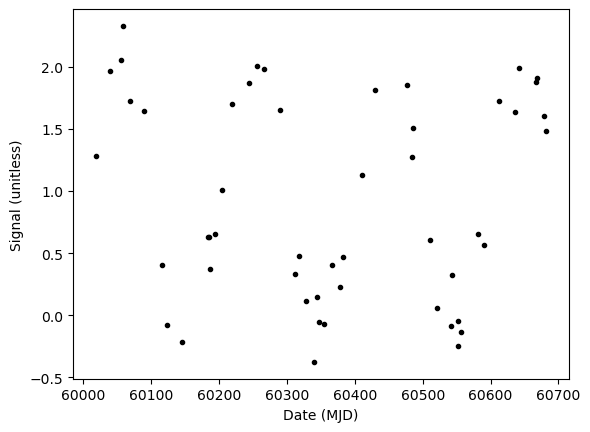

In [20]:
num_obs = 50
MJDs = np.sort(np.random.uniform(60000, 60700, num_obs))

signal = sine_signal(MJDs)

noise = np.random.normal(loc=0, scale=0.25, size=num_obs)

obs_signal = signal + noise

plt.plot(MJDs, obs_signal, 'k.')
plt.xlabel('Date (MJD)')
plt.ylabel('Signal (unitless)')
plt.show()

Now we compute a Lomb-Scargle periodogram, from the `astropy.timeseries` module. The full documentation can be found [here](https://docs.astropy.org/en/stable/timeseries/lombscargle.html). A periodic signal should generate a periodogram with a peak at the frequency of the signal.

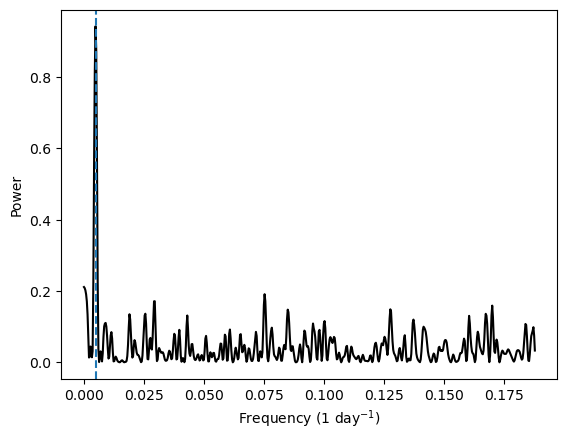

Periodicity at 201.36207187460965 days.


In [21]:
from astropy.timeseries import LombScargle

frequency, power = LombScargle(MJDs, obs_signal).autopower()

plt.plot(frequency, power, 'k')
plt.axvline(x=1/200, linestyle='--')
plt.xlabel('Frequency (1 day$^{-1}$)')
plt.ylabel('Power')
plt.show()

print('Periodicity at {} days.'.format(1/frequency[(power == np.max(power))][0]))

We see a big spike right near the frequency of 1/(200 days)! That's strong evidence of a periodic signal -- even though it wasn't that obvious when we plotted the signal.

The `.autopower()` option means that `LombScargle` will automatically pick the frequencies to search over. However, we could, if we wanted, pick our own frequency range to search, then compute a periodogram using `.power()` instead of `.autopower()`:

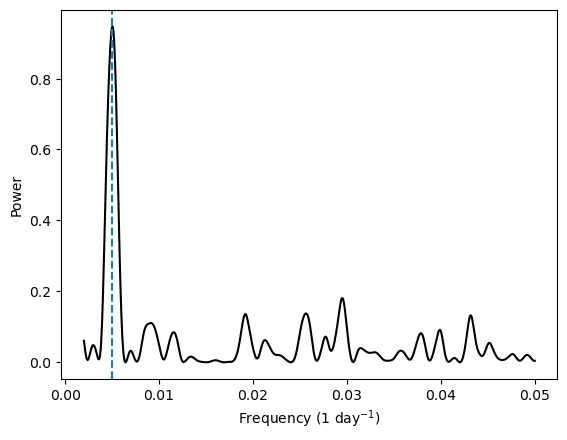

In [22]:
new_frequency = np.linspace(0.002, 0.05, 1000)
new_power = LombScargle(MJDs, obs_signal).power(new_frequency)

plt.plot(new_frequency, new_power, 'k')
plt.axvline(x=1/200, linestyle='--')
plt.xlabel('Frequency (1 day$^{-1}$)')
plt.ylabel('Power')
plt.show()

There are very specific ways to calculate the right range of frequencies to search, which we won't get into here.

You might be wondering how we calculate the statistical significance of peaks in a periodogram. There are several other peaks in our plots; why shouldn't we believe them? Similarly, why *should* we believe that the highest peak is real?

To answer these questions, we're going to use a technique called bootstrapping. Say we know that a given peak in our periodogram has a height $H$. We want to calculate the significance of that peak. We do so by carrying out the following procedure a bunch of times:
1. Create a new, fake signal generated by randomly rearranging the values assigned to each day. This signal consists of random noise.
2. Compute the Lomb-Scargle periodogram of that signal.
3. Calculate the highest point on that periodogram, and denote its height $H_i$.

After following through those steps many times, we can assign a significance called a $p$-value to our original peak. Here, the $p$-value is the fraction of the fake signals with $H_i$ greater than or equal to $H$. For instance, if we randomize the data 100 times and 66 of them have $H_i\geq H$, we would say that the $p$-value is $66/100=0.66$. Typically, we want $p$ to be below a certain threshold to say that the peak is significant. $0.05$ is a common choice in some scenarios. Since $0.66$ is much greater than $0.05$, we conclude that this peak is not significant.

Let's calculate a $p$-value for the periodicity we found, using `.autopower()` and $n=10000$ simulations. Here are some hints to help you:
- You can find the maximum value of an array using `np.max()`.
- You can create a shuffled copy of `obs_signal` with `fake_signal = np.copy(obs_signal)` and then `np.random.shuffle(fake_signal)`.

Keep in mind that the peak might be so strong that none of the simulations produce a peak that high!

In [24]:
max_power = np.max(power)
N = 10000
num_above = 0
for i in range(N):
    fake_signal = np.copy(obs_signal)
    np.random.shuffle(fake_signal)
    
    sim_freq, sim_power = LombScargle(MJDs, fake_signal).autopower()
    if np.max(sim_power) >= max_power:
        num_above += 1
p = num_above/N
print(p)

0.0
